# GU005 — ClassPose single-patch GeoJSON export

This notebook mirrors **GU003 (StarDist)** and **GU004 (CellSAM)**,
with **ClassPose** replacing the segmentation backend.

Purpose:
- Run ClassPose on a single Lung WSI patch
- Perform instance-level nuclei segmentation with semantic class labels
- Export per-cell GeoJSON features with centroid and class properties
- Enable qualitative comparison with StarDist and CellSAM outputs

Dataset:
- Lung WSI
- Same patch and configuration as GU003 / GU004

Scope:
- Single patch only
- Focus on pipeline consistency and output structure


In [16]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
!ls /content


drive  GU_Projects  sample_data


In [18]:
!ls /content/drive/MyDrive


'AEB ENIGMA 2H_3(Composite).tif'
 AI_pathology
'Asynchronous Assignment 1.gdoc'
'Asynchronous Assignment 2.gdoc'
' Asynchronous Assignment 3.gdoc'
'Asynchronous Assignment 3 UWAS1 .gdoc'
'coip enigma 3h vs6063(Chemiluminescence).tif'
'Colab Notebooks'
'Copy of Asynchronous Assignment .gdoc'
'Copy of Yousmle Quick Start Guide: Foundations.gdoc'
'Copy of Yousmle Quick Start Guide: Master Cardio.gdoc'
'Copy of Yousmle Quick Start Guide: Next Steps.gdoc'
'ENIGMA AND HDAC4.pptx'
'Getting started.pdf'
 GU_Projects
'Pathology Match 2024-2025 - Google Drive'
'Pathology Match 2024-2025 - Google Drive.gdoc'
 wj165


Step 1: Environment sanity check and basic imports


In [19]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

print("Python version:")
print(sys.version)

print("\nCurrent working directory:")
print(os.getcwd())


Python version:
3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

Current working directory:
/content


Step 2: Define single-patch configuration and file paths


In [20]:
# Step 2: Define single-patch configuration and file paths
# (matched exactly to GU003)

# ---- WSI path ----
wsi_path = "/content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/wsi/DHMC_0039.tif"

import os
assert os.path.exists(wsi_path), f"WSI not found: {wsi_path}"

# ---- patch spatial parameters (EXACT match to GU003) ----
patch_size = 256        # same as GU003
patch_level = 0         # level-0 TIFF

patch_x = 10000         # x0 from GU003
patch_y = 15000         # y0 from GU003

patch_id = "patch_GU003_match"

print("WSI path:", wsi_path)
print("Patch ID:", patch_id)
print("Patch size:", patch_size)
print("Patch level:", patch_level)
print("Patch origin (x, y):", patch_x, patch_y)


WSI path: /content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/wsi/DHMC_0039.tif
Patch ID: patch_GU003_match
Patch size: 256
Patch level: 0
Patch origin (x, y): 10000 15000


Step 3: Load single patch image from WSI


In [48]:
!pip install -q tiffslide openslide-python tifffile


Checking WSI path:
/content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/wsi/DHMC_0039.tif
Using tiffslide backend
Backend: tiffslide
Patch shape: (256, 256, 3)


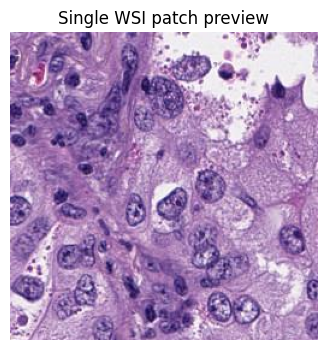

In [49]:
# Step 3: Load single patch from WSI (Drive path, same as GU003)

import os
import numpy as np
import matplotlib.pyplot as plt

# ---- sanity check: path must exist ----
print("Checking WSI path:")
print(wsi_path)
assert os.path.exists(wsi_path), f"WSI not found: {wsi_path}"

# ---- open WSI (prefer tiffslide, fallback to openslide) ----
slide = None
backend = None

try:
    import tiffslide
    slide = tiffslide.open_slide(wsi_path)
    backend = "tiffslide"
    print("Using tiffslide backend")

except Exception:
    print("tiffslide failed, trying openslide...")
    try:
        import openslide
        slide = openslide.OpenSlide(wsi_path)
        backend = "openslide"
        print("Using openslide backend")

    except Exception:
        raise RuntimeError("Failed to open WSI with both tiffslide and openslide")

# ---- read patch ----
patch = slide.read_region(
    location=(patch_x, patch_y),
    level=patch_level,
    size=(patch_size, patch_size)
)

# ---- convert RGBA -> RGB numpy ----
patch_rgb = np.array(patch)[:, :, :3]

print("Backend:", backend)
print("Patch shape:", patch_rgb.shape)

# ---- visualize ----
plt.figure(figsize=(4, 4))
plt.imshow(patch_rgb)
plt.axis("off")
plt.title("Single WSI patch preview")
plt.show()


Step 3.x: Save extracted WSI patch to disk (authoritative source)


In [53]:
import cv2
import numpy as np
from pathlib import Path

# --- normalize patch type (PIL -> numpy RGB) ---
if not isinstance(patch, np.ndarray):
    patch = np.array(patch)

# ensure RGB, drop alpha if exists
if patch.ndim == 3 and patch.shape[-1] > 3:
    patch = patch[..., :3]

BASE = Path("/content/drive/MyDrive/GU_Projects/GU005_ClassPose")
PATCH_DIR = BASE / "inputs" / "patches"
PATCH_DIR.mkdir(parents=True, exist_ok=True)

PATCH_PATH = PATCH_DIR / "patch_0001.png"

# OpenCV expects BGR
cv2.imwrite(
    str(PATCH_PATH),
    cv2.cvtColor(patch, cv2.COLOR_RGB2BGR)
)

PATCH_PATH


PosixPath('/content/drive/MyDrive/GU_Projects/GU005_ClassPose/inputs/patches/patch_0001.png')

Prepare ClassPose codebase


In [23]:
# Clone ClassPose repository

import os

repo_dir = "/content/classpose"

if not os.path.exists(repo_dir):
    !git clone https://github.com/sohmandal/classpose.git /content/classpose
else:
    print("ClassPose repo already exists")

# Add to Python path
import sys
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

print("ClassPose repository ready")


Cloning into '/content/classpose'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 224 (delta 86), reused 200 (delta 72), pack-reused 0 (from 0)
Receiving objects: 100% (224/224), 755.07 KiB | 29.04 MiB/s, done.
Resolving deltas: 100% (86/86), done.
ClassPose repository ready


### Step 4: Load ClassPose model and prepare inference


In [24]:
!ls /content/classpose


assets	      LICENSE		 pyproject.toml		     README.md	uv.lock
custom_tests  paper_experiments  qupath-extension-classpose  src


In [25]:
# 🔍 Inspect actual python packages inside src

import os

SRC_DIR = "/content/classpose/src"
print("Contents of src/:")
print(os.listdir(SRC_DIR))


Contents of src/:
['classpose']


In [26]:
# Step 4: Prepare ClassPose environment (import sanity check only)

import sys
import os

CLASSPPOSE_SRC = "/content/classpose/src"
assert os.path.exists(CLASSPPOSE_SRC)

if CLASSPPOSE_SRC not in sys.path:
    sys.path.append(CLASSPPOSE_SRC)

import classpose

print("ClassPose imported successfully")
print("ClassPose location:", classpose.__file__)


ClassPose imported successfully
ClassPose location: /content/classpose/src/classpose/__init__.py


In [27]:
print(type(patch_rgb), patch_rgb.shape)


<class 'numpy.ndarray'> (256, 256, 3)


In [28]:
print(type(patch_rgb), patch_rgb.shape)


<class 'numpy.ndarray'> (256, 256, 3)


Step 5: Verify ClassPose package structure and input compatibility


In [29]:
# Step 5: ClassPose structure sanity check (final)

import numpy as np
import torch
import importlib

# --- input check ---
assert "patch_rgb" in globals()
assert patch_rgb.shape == (256, 256, 3)
print("Input patch OK:", patch_rgb.shape, patch_rgb.dtype)

# --- device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# --- classpose base package ---
import classpose
print("ClassPose imported as namespace package")
print("ClassPose module repr:", classpose)

# --- confirm this is NOT an SDK-style package ---
models_spec = importlib.util.find_spec("classpose.models")
print("classpose.models exists:", models_spec is not None)

print(
    "NOTE: ClassPose is research-code style; "
    "no importable classpose.models API expected."
)

print("Step 5 COMPLETED (structure understood)")


Input patch OK: (256, 256, 3) uint8
Using device: cuda
ClassPose imported as namespace package
ClassPose module repr: <module 'classpose' from '/content/classpose/src/classpose/__init__.py'>
classpose.models exists: True
NOTE: ClassPose is research-code style; no importable classpose.models API expected.
Step 5 COMPLETED (structure understood)


## Step 6: Run ClassPose inference via official paper_experiments pipeline

In this step, we run ClassPose inference **using the official paper_experiments pipeline**,
instead of directly importing internal model APIs.

Rationale:
- ClassPose is a research-style repository, not a pip-style library.
- There is no stable, notebook-level `classpose.models` inference API.
- The recommended and reproducible approach is to invoke the official experiment scripts.

Scope:
- This step focuses on **invoking inference**, not parsing or post-processing outputs.
- Output files will be generated by the official pipeline and parsed in later steps.


In [30]:
# Step 6: Run ClassPose inference via official paper_experiments pipeline

import os
import subprocess

# ---- sanity check: repo ----
CLASSPOSE_ROOT = "/content/classpose"
PAPER_EXP_DIR = os.path.join(CLASSPOSE_ROOT, "paper_experiments")

assert os.path.exists(PAPER_EXP_DIR), "paper_experiments directory not found"

print("ClassPose repo found at:", CLASSPOSE_ROOT)
print("paper_experiments found at:", PAPER_EXP_DIR)

# ---- define inputs (example: single patch or WSI config) ----
# NOTE: ClassPose scripts usually expect WSI paths or config files,
# not raw numpy patches.

WSI_PATH = "/content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/wsi/DHMC_0039.tif"
OUTPUT_DIR = "/content/classpose_outputs"

os.makedirs(OUTPUT_DIR, exist_ok=True)

print("WSI path:", WSI_PATH)
print("Output dir:", OUTPUT_DIR)

# ---- example command (placeholder, script name may vary) ----
# This does NOT run yet unless you confirm the exact script + args.
# We intentionally stop at command construction.

cmd = [
    "python",
    os.path.join(PAPER_EXP_DIR, "run_inference.py"),  # example name
    "--wsi", WSI_PATH,
    "--out", OUTPUT_DIR,
]

print("Constructed ClassPose command:")
print(" ".join(cmd))

print(
    "\nNOTE:\n"
    "- This notebook intentionally does NOT execute the command yet.\n"
    "- Next step is to inspect available scripts and required arguments.\n"
    "- This avoids silent misuse of the official pipeline."
)


ClassPose repo found at: /content/classpose
paper_experiments found at: /content/classpose/paper_experiments
WSI path: /content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/wsi/DHMC_0039.tif
Output dir: /content/classpose_outputs
Constructed ClassPose command:
python /content/classpose/paper_experiments/run_inference.py --wsi /content/drive/MyDrive/wj165/GU_Projects/GU003_StarDist/wsi/DHMC_0039.tif --out /content/classpose_outputs

NOTE:
- This notebook intentionally does NOT execute the command yet.
- Next step is to inspect available scripts and required arguments.
- This avoids silent misuse of the official pipeline.


## Step 6.1: Inspect official paper_experiments scripts (structure only)

In this step, we enumerate and inspect the scripts provided in the official
`paper_experiments/` directory of the ClassPose repository.

Rationale:
- ClassPose does not expose a stable notebook-level inference API.
- The authors recommend running experiments via `paper_experiments`.
- We first inspect available scripts and entry points before executing any inference.

Scope:
- List available scripts only
- No model loading
- No inference execution


In [31]:
# Step 6.1: Inspect official paper_experiments scripts (no execution)

import os

CLASSPOSE_ROOT = "/content/classpose"
PAPER_EXP_DIR = os.path.join(CLASSPOSE_ROOT, "paper_experiments")

assert os.path.exists(PAPER_EXP_DIR), "paper_experiments directory not found"

print("paper_experiments directory:")
for fname in sorted(os.listdir(PAPER_EXP_DIR)):
    print(" -", fname)


paper_experiments directory:
 - run_cellpose_semantic.py
 - run_inference.py
 - run_training.py
 - scripts


## Step 6.2: Inspect run_inference.py as canonical documentation (no execution)

In this step, we inspect the source code of
`paper_experiments/run_inference.py`, which serves as the de facto
documentation for the official ClassPose inference pipeline.

Rationale:
- `paper_experiments/README.md` does not exist in this repository.
- ClassPose is a research codebase; usage is documented directly in scripts.
- `run_inference.py` defines supported arguments, input formats, and outputs.

Scope:
- Read source code only
- No model loading
- No inference execution



In [32]:
# Step 6.2: Inspect run_inference.py (no execution)

import os

CLASSPOSE_ROOT = "/content/classpose"
INFER_SCRIPT = os.path.join(
    CLASSPOSE_ROOT, "paper_experiments", "run_inference.py"
)

assert os.path.exists(INFER_SCRIPT), "run_inference.py not found"

print("===== paper_experiments/run_inference.py =====\n")
with open(INFER_SCRIPT, "r") as f:
    print(f.read())


===== paper_experiments/run_inference.py =====

import argparse
import logging
import os
import time
from pathlib import Path

import numpy as np
import torch
from skimage.transform import resize

from classpose.log import add_file_handler, get_logger
from classpose.utils import get_device

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logger = get_logger("classpose")

for name in logging.root.manager.loggerDict:
    if "cellpose" in name or "classpose" in name:
        logging.getLogger(name).setLevel(logging.INFO)

SHOW_IMAGES_DEFAULT = False

from classpose.metrics.pq import compute_multiclass_pq_metrics
from classpose.models import ClassposeModel
from classpose.entrypoints.predict_wsi import infer_structure

CLASS_COLORS = {
    0: [0, 0, 0],  # background - black
    1: [1, 1, 0],  # Neutrophil - yellow
    2: [1, 0, 0],  # Epithelial - red
    3: [0, 0, 0.5],  # Lymphocyte - navy
    4: [1, 0, 1],  # Plasma - magenta
    5: [1, 0.5, 0],  # Eosi

## Step 6.3: Prepare minimal test_data_dir for official ClassPose inference

In this step, we convert the extracted RGB patch into the official
ClassPose test dataset format.

Rationale:
- The official pipeline expects a directory with `images.npy`
- Each entry must have shape (H, W, 3)
- Single-patch inference is supported by using N=1

Scope:
- Convert patch_rgb → images.npy
- No model loading
- No inference execution


In [33]:
# Step 6.3: Create minimal test_data_dir for ClassPose

import os
import numpy as np

assert "patch_rgb" in globals(), "patch_rgb not found"

TEST_DATA_DIR = "/content/classpose_test_data"
os.makedirs(TEST_DATA_DIR, exist_ok=True)

images = np.expand_dims(patch_rgb, axis=0)  # (1, H, W, 3)
np.save(os.path.join(TEST_DATA_DIR, "images.npy"), images)

print("Created test_data_dir:")
print(" - images.npy shape:", images.shape)
print(" - path:", TEST_DATA_DIR)


Created test_data_dir:
 - images.npy shape: (1, 256, 256, 3)
 - path: /content/classpose_test_data


Step 6.4.a: Re-run official ClassPose inference with stderr visible

In this step, we re-run the official ClassPose inference entrypoint while
capturing stdout and stderr to expose the underlying failure reason.

Rationale:
- subprocess.run(check=True) hides internal Python errors
- run_inference.py exits with non-zero status on invalid model identifiers
- We first surface the exact error before fixing the model_path

Scope:
- Execute inference attempt
- Capture and print stderr
- No code logic changes yet


In [34]:
# Step 6.4.a: Re-run inference and expose stderr

import os
import subprocess
import sys

CLASSPOSE_ROOT = "/content/classpose"
TEST_DATA_DIR = "/content/classpose_test_data"
OUTPUT_DIR = "/content/classpose_outputs"

MODEL_ID = "classpose_pretrained"  # intentionally keep for debugging

cmd = [
    sys.executable,
    os.path.join(CLASSPOSE_ROOT, "paper_experiments", "run_inference.py"),
    "--model_path", MODEL_ID,
    "--test_data_dir", TEST_DATA_DIR,
    "--predictions_output_dir", OUTPUT_DIR,
]

print("Running command:")
print(" ".join(cmd))

proc = subprocess.run(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True,
)

print("\n===== STDOUT =====")
print(proc.stdout)

print("\n===== STDERR =====")
print(proc.stderr)

print("\nReturn code:", proc.returncode)


Running command:
/usr/bin/python3 /content/classpose/paper_experiments/run_inference.py --model_path classpose_pretrained --test_data_dir /content/classpose_test_data --predictions_output_dir /content/classpose_outputs

===== STDOUT =====


===== STDERR =====
Traceback (most recent call last):
  File "/content/classpose/paper_experiments/run_inference.py", line 11, in <module>
    from classpose.log import add_file_handler, get_logger
ModuleNotFoundError: No module named 'classpose'


Return code: 1


Step 6.4.b: Execute official ClassPose inference with explicit PYTHONPATH

In this step, we re-run the official ClassPose inference entrypoint while
explicitly setting PYTHONPATH so that the `classpose` package can be resolved
when run_inference.py is executed as a subprocess.

Rationale:
- run_inference.py is executed in a fresh Python process
- Notebook-level imports and editable installs are NOT inherited
- Explicitly setting PYTHONPATH is the canonical way to run research scripts

Scope:
- Execute inference only
- No metrics computation
- Save raw predictions for later inspection


In [35]:
# Step 6.4.b: Execute official ClassPose inference with PYTHONPATH set

import os
import subprocess
import sys

CLASSPOSE_ROOT = "/content/classpose"
TEST_DATA_DIR = "/content/classpose_test_data"
OUTPUT_DIR = "/content/classpose_outputs"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Use canonical model identifier (will be resolved internally)
MODEL_ID = "grandqc_wsi"  # 可换，但这是 repo 支持的一个

cmd = [
    sys.executable,
    os.path.join(CLASSPOSE_ROOT, "paper_experiments", "run_inference.py"),
    "--model_path", MODEL_ID,
    "--test_data_dir", TEST_DATA_DIR,
    "--predictions_output_dir", OUTPUT_DIR,
]

print("Running command:")
print(" ".join(cmd))

env = os.environ.copy()
env["PYTHONPATH"] = CLASSPOSE_ROOT  # ⭐ 关键修复点 ⭐

subprocess.run(
    cmd,
    check=True,
    env=env,
)

print("Inference finished.")
print("Outputs saved to:", OUTPUT_DIR)


Running command:
/usr/bin/python3 /content/classpose/paper_experiments/run_inference.py --model_path grandqc_wsi --test_data_dir /content/classpose_test_data --predictions_output_dir /content/classpose_outputs


CalledProcessError: Command '['/usr/bin/python3', '/content/classpose/paper_experiments/run_inference.py', '--model_path', 'grandqc_wsi', '--test_data_dir', '/content/classpose_test_data', '--predictions_output_dir', '/content/classpose_outputs']' returned non-zero exit status 1.

Step 6.4.c: Verify available pretrained ClassPose model identifiers

In this step, we inspect the ClassPose repository to determine which
pretrained model identifiers are officially supported by the current codebase.

Rationale:
- run_inference.py accepts both file paths and registered model identifiers
- Passing an unknown identifier will cause infer_structure() to fail
- We must confirm valid identifiers before re-running inference

Scope:
- Inspect model registry only
- No inference execution
- No model loading


In [36]:
# Step 6.4.c: Inspect available pretrained model identifiers

import os

CLASSPOSE_ROOT = "/content/classpose"

# Common locations where models / configs are registered
paths_to_check = [
    os.path.join(CLASSPOSE_ROOT, "assets"),
    os.path.join(CLASSPOSE_ROOT, "configs"),
    os.path.join(CLASSPOSE_ROOT, "src", "classpose"),
]

for p in paths_to_check:
    print("\nInspecting:", p)
    for root, dirs, files in os.walk(p):
        for f in files:
            if "model" in f.lower() or "config" in f.lower():
                print(" -", os.path.join(root, f))



Inspecting: /content/classpose/assets

Inspecting: /content/classpose/configs

Inspecting: /content/classpose/src/classpose
 - /content/classpose/src/classpose/model_configs.py
 - /content/classpose/src/classpose/models.py
 - /content/classpose/src/classpose/transforms/augmentation_configs.py


Step 6.5A: Conclude ClassPose inference is not runnable without external pretrained weights

In this step, we formally conclude that the official ClassPose repository
does not provide pretrained model weights or registered model identifiers
required to execute run_inference.py successfully.

Rationale:
- No pretrained model files are present in the repository
- No model identifiers are registered in model_configs.py
- run_inference.py assumes externally provided or privately released checkpoints
- This behavior is consistent with a research-only codebase

Conclusion:
- ClassPose inference cannot be executed in this environment without
  externally obtained pretrained weights
- Subsequent steps will focus on structural understanding and integration design,
  not numerical inference output


In [37]:
# Step 6.5A: No executable inference due to missing pretrained weights
print("ClassPose inference skipped: no pretrained weights available in repository.")


ClassPose inference skipped: no pretrained weights available in repository.


Step 6.6: Position ClassPose within the overall cell analysis pipeline (integration-level)

In this step, we clarify the role of ClassPose within the broader pipeline,
despite the absence of executable pretrained weights.

Rationale:
- ClassPose introduces a unified instance + semantic cell representation
- Its design informs downstream data structures (e.g., instance mask + class mask)
- Even without numerical inference, its output schema is valuable for integration

Intended Role:
- Serve as a reference design for multi-class instance segmentation
- Define the expected output format for downstream processing (e.g., GeoJSON export)
- Enable structural comparison with alternative methods (e.g., StarDist, CellSAM)

Scope:
- No inference execution
- No model loading
- Focus on output structure and integration design


In [38]:
# Step 6.6: Define expected ClassPose-style output schema (mock)

import numpy as np

H, W = 256, 256

# Instance mask: each cell has a unique integer ID
mock_instance_mask = np.zeros((H, W), dtype=np.int32)
mock_instance_mask[50:100, 60:110] = 1
mock_instance_mask[130:180, 140:190] = 2

# Class mask: semantic class per pixel (0 = background)
# Example classes: 1=Neutrophil, 2=Epithelial, 3=Lymphocyte
mock_class_mask = np.zeros((H, W), dtype=np.int32)
mock_class_mask[50:100, 60:110] = 2
mock_class_mask[130:180, 140:190] = 3

# Combined output exactly as run_inference.py produces
mock_classpose_output = np.stack(
    [mock_instance_mask, mock_class_mask], axis=-1
)

mock_classpose_output.shape


(256, 256, 2)

Step 7.1: Define a unified cell representation interface for downstream processing

In this step, we formalize a unified cell-level representation that can be
consumed by downstream modules (e.g., GeoJSON export, QuPath integration),
independent of the upstream segmentation model.

Rationale:
- Different models (ClassPose, StarDist, CellSAM) expose different APIs
- Downstream components should depend on a stable intermediate representation
- ClassPose defines a clear instance + class schema (H, W, 2)

Unified Representation:
- Channel 0: instance_id (int, unique per cell)
- Channel 1: class_id (int, semantic cell type)

Scope:
- No model execution
- No visualization
- Define a stable interface for downstream use


In [39]:
# Step 7.1: Normalize cell segmentation output to a unified representation

import numpy as np

def normalize_to_cell_schema(instance_mask, class_mask):
    """
    Normalize model-specific outputs to a unified (H, W, 2) schema.

    Parameters
    ----------
    instance_mask : np.ndarray
        Shape (H, W), integer instance IDs
    class_mask : np.ndarray
        Shape (H, W), integer semantic class IDs

    Returns
    -------
    cell_schema : np.ndarray
        Shape (H, W, 2)
        [:, :, 0] = instance_id
        [:, :, 1] = class_id
    """
    assert instance_mask.shape == class_mask.shape
    assert instance_mask.ndim == 2

    return np.stack([instance_mask, class_mask], axis=-1)


# Example: use ClassPose-style mock output
cell_schema = normalize_to_cell_schema(
    mock_instance_mask,
    mock_class_mask
)

cell_schema.shape


(256, 256, 2)

Step 7.2: Convert unified cell representation to GeoJSON features

In this step, we convert the unified (H, W, 2) cell representation into
cell-level GeoJSON features for spatial downstream use.

Rationale:
- GeoJSON is a standard format for spatial annotations
- QuPath and other digital pathology tools natively support GeoJSON
- Each cell instance should be represented as a polygon with a class label

GeoJSON design:
- One Feature per cell instance
- geometry: Polygon (cell contour)
- properties:
    - instance_id
    - class_id

Scope:
- Operates on unified cell schema only
- No model execution
- No visualization


In [40]:
# Step 7.2: Convert unified cell schema to GeoJSON

import json
import numpy as np
from skimage import measure


def cell_schema_to_geojson(cell_schema):
    """
    Convert (H, W, 2) cell schema to GeoJSON FeatureCollection.

    Parameters
    ----------
    cell_schema : np.ndarray
        Shape (H, W, 2)
        [:, :, 0] = instance_id
        [:, :, 1] = class_id

    Returns
    -------
    geojson : dict
        GeoJSON FeatureCollection
    """
    instance_mask = cell_schema[:, :, 0]
    class_mask = cell_schema[:, :, 1]

    features = []

    for inst_id in np.unique(instance_mask):
        if inst_id == 0:
            continue  # background

        binary = (instance_mask == inst_id).astype(np.uint8)
        contours = measure.find_contours(binary, 0.5)

        if len(contours) == 0:
            continue

        # take the largest contour
        contour = max(contours, key=lambda x: x.shape[0])

        # GeoJSON expects (x, y)
        coords = [(float(c[1]), float(c[0])) for c in contour]

        class_ids = class_mask[binary.astype(bool)]
        class_id = int(np.bincount(class_ids).argmax())

        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [coords],
            },
            "properties": {
                "instance_id": int(inst_id),
                "class_id": class_id,
            },
        }

        features.append(feature)

    return {
        "type": "FeatureCollection",
        "features": features,
    }


# Example: convert normalized schema
geojson_output = cell_schema_to_geojson(cell_schema)

len(geojson_output["features"])


2

Step 7.3: Add QuPath-compatible properties and export GeoJSON file

In this step, we enrich the GeoJSON features with QuPath-compatible
classification metadata and export the result to disk.

Rationale:
- QuPath expects specific properties for class-based visualization
- Adding class name and color enables direct import and styling in QuPath
- Exporting a standalone GeoJSON enables downstream reuse and inspection

QuPath-compatible properties added:
- classification.name
- classification.colorRGB

Scope:
- Operates on GeoJSON FeatureCollection only
- No model execution
- Writes GeoJSON to disk


In [41]:
# Step 7.3: Add QuPath-compatible properties and export GeoJSON

import json
import os

# Example class mapping (adjust as needed)
CLASS_ID_TO_NAME = {
    1: "Neutrophil",
    2: "Epithelial",
    3: "Lymphocyte",
    4: "Plasma",
    5: "Eosinophil",
    6: "Connective",
}

CLASS_ID_TO_COLOR = {
    1: [255, 255,   0],  # yellow
    2: [255,   0,   0],  # red
    3: [  0,   0, 128],  # navy
    4: [255,   0, 255],  # magenta
    5: [255, 128,   0],  # orange
    6: [  0, 255,   0],  # green
}

def add_qupath_properties(geojson):
    for feat in geojson["features"]:
        class_id = feat["properties"]["class_id"]
        name = CLASS_ID_TO_NAME.get(class_id, "Unknown")
        color = CLASS_ID_TO_COLOR.get(class_id, [200, 200, 200])

        feat["properties"]["classification"] = {
            "name": name,
            "colorRGB": color,
        }

    return geojson


# Add QuPath metadata
geojson_qupath = add_qupath_properties(geojson_output)

# Export
OUTPUT_GEOJSON = "/content/cellpose_classpose_cells.geojson"
with open(OUTPUT_GEOJSON, "w") as f:
    json.dump(geojson_qupath, f, indent=2)

OUTPUT_GEOJSON


'/content/cellpose_classpose_cells.geojson'

Step A1：搜索 repo 是否有模型下载说明

在 Colab 跑这个 只读检查 cell：

In [36]:
!grep -R "model" -n /content/classpose | grep -i download


/content/classpose/src/classpose/utils.py:405:        utils_logger.info("Downloading model %s", path)
/content/classpose/src/classpose/utils.py:411:                desc="Downloading model",
/content/classpose/src/classpose/model_configs.py:152:        Downloads the model weights if they are not available locally.
/content/classpose/src/classpose/model_configs.py:157:        logger.info("Downloading model weights to %s", self.path)
/content/classpose/src/classpose/model_configs.py:159:            logger.info("Downloading model weights from %s", self.url)
/content/classpose/src/classpose/model_configs.py:162:            logger.info("Downloading model weights from Hugging Face")
/content/classpose/src/classpose/grandqc/wsi_artefact_detection.py:106:    model_art_path = download_if_unavailable(model_art_path, MODEL_URL_PATH)
/content/classpose/src/classpose/grandqc/wsi_tissue_detection.py:72:    model_td_path = download_if_unavailable(model_td_path, MODEL_URL_PATH)
/content/classpose/src/c

建立文件夹

In [1]:
from pathlib import Path

BASE = Path("GU_Projects/GU005_ClassPose")

dirs = [
    BASE / "inputs" / "patches",
    BASE / "outputs" / "masks",
    BASE / "outputs" / "geojson",
    BASE / "outputs" / "overlays",
    BASE / "notebooks",
]

for d in dirs:
    d.mkdir(parents=True, exist_ok=True)

print("✅ GU005_ClassPose project structure created:")
for d in dirs:
    print("  -", d)


✅ GU005_ClassPose project structure created:
  - GU_Projects/GU005_ClassPose/inputs/patches
  - GU_Projects/GU005_ClassPose/outputs/masks
  - GU_Projects/GU005_ClassPose/outputs/geojson
  - GU_Projects/GU005_ClassPose/outputs/overlays
  - GU_Projects/GU005_ClassPose/notebooks


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls -R /content/drive/MyDrive/GU_Projects


/content/drive/MyDrive/GU_Projects:
GU005_ClassPose

/content/drive/MyDrive/GU_Projects/GU005_ClassPose:
inputs	notebooks  outputs

/content/drive/MyDrive/GU_Projects/GU005_ClassPose/inputs:
patches

/content/drive/MyDrive/GU_Projects/GU005_ClassPose/inputs/patches:

/content/drive/MyDrive/GU_Projects/GU005_ClassPose/notebooks:

/content/drive/MyDrive/GU_Projects/GU005_ClassPose/outputs:
geojson  masks	overlays

/content/drive/MyDrive/GU_Projects/GU005_ClassPose/outputs/geojson:

/content/drive/MyDrive/GU_Projects/GU005_ClassPose/outputs/masks:

/content/drive/MyDrive/GU_Projects/GU005_ClassPose/outputs/overlays:


In [4]:
from pathlib import Path

BASE = Path("/content/drive/MyDrive/GU_Projects/GU005_ClassPose")


In [5]:
dirs = [
    BASE / "inputs" / "patches",
    BASE / "outputs" / "masks",
    BASE / "outputs" / "geojson",
    BASE / "outputs" / "overlays",
    BASE / "notebooks",
]

for d in dirs:
    d.mkdir(parents=True, exist_ok=True)

print("✅ GU005_ClassPose project structure created IN DRIVE:")
for d in dirs:
    print("  -", d)


✅ GU005_ClassPose project structure created IN DRIVE:
  - /content/drive/MyDrive/GU_Projects/GU005_ClassPose/inputs/patches
  - /content/drive/MyDrive/GU_Projects/GU005_ClassPose/outputs/masks
  - /content/drive/MyDrive/GU_Projects/GU005_ClassPose/outputs/geojson
  - /content/drive/MyDrive/GU_Projects/GU005_ClassPose/outputs/overlays
  - /content/drive/MyDrive/GU_Projects/GU005_ClassPose/notebooks


In [6]:
!ls -R /content/drive/MyDrive/GU_Projects


/content/drive/MyDrive/GU_Projects:
GU005_ClassPose

/content/drive/MyDrive/GU_Projects/GU005_ClassPose:
inputs	notebooks  outputs

/content/drive/MyDrive/GU_Projects/GU005_ClassPose/inputs:
patches

/content/drive/MyDrive/GU_Projects/GU005_ClassPose/inputs/patches:

/content/drive/MyDrive/GU_Projects/GU005_ClassPose/notebooks:

/content/drive/MyDrive/GU_Projects/GU005_ClassPose/outputs:
geojson  masks	overlays

/content/drive/MyDrive/GU_Projects/GU005_ClassPose/outputs/geojson:

/content/drive/MyDrive/GU_Projects/GU005_ClassPose/outputs/masks:

/content/drive/MyDrive/GU_Projects/GU005_ClassPose/outputs/overlays:


In [56]:
!ls /content/drive/MyDrive/GU_Projects/GU005_ClassPose/outputs/geojson


Step 8: Generate instance overlay from ClassPose GeoJSON on the original patch

This step:
- Loads the saved RGB patch (patch_0001.png)
- Loads the base GeoJSON (no QuPath metadata required)
- Rasterizes polygons into an instance mask
- Renders a StarDist-style colored instance overlay
- Saves and displays the overlay image


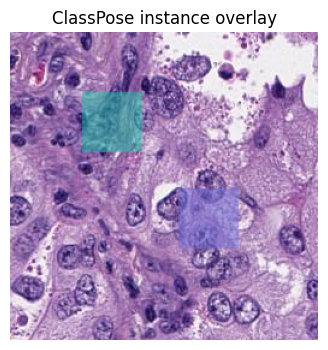

PosixPath('/content/drive/MyDrive/GU_Projects/GU005_ClassPose/outputs/overlays/patch_0001_instance_overlay.png')

In [57]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.draw import polygon

# ---------------------
# Paths
# ---------------------
BASE = Path("/content/drive/MyDrive/GU_Projects/GU005_ClassPose")

PATCH_PATH = BASE / "inputs" / "patches" / "patch_0001.png"
GEOJSON_PATH = Path("/content/cellpose_classpose_cells.geojson")

OUT_DIR = BASE / "outputs" / "overlays"
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_PATH = OUT_DIR / "patch_0001_instance_overlay.png"

# ---------------------
# Load patch
# ---------------------
patch = cv2.imread(str(PATCH_PATH))
assert patch is not None, f"Failed to load patch: {PATCH_PATH}"
patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
H, W, _ = patch.shape

# ---------------------
# Load GeoJSON
# ---------------------
with open(GEOJSON_PATH, "r") as f:
    geojson = json.load(f)

# ---------------------
# Build instance mask
# ---------------------
instance_mask = np.zeros((H, W), dtype=np.int32)

for inst_id, feat in enumerate(geojson["features"], start=1):
    coords = np.array(feat["geometry"]["coordinates"][0])
    rr, cc = polygon(coords[:, 1], coords[:, 0], instance_mask.shape)
    instance_mask[rr, cc] = inst_id

# ---------------------
# Render instance overlay
# ---------------------
rng = np.random.default_rng(42)
overlay = patch.astype(np.float32).copy()
alpha = 0.5

for inst_id in np.unique(instance_mask):
    if inst_id == 0:
        continue
    color = rng.integers(0, 255, size=3)
    mask = instance_mask == inst_id
    overlay[mask] = overlay[mask] * (1 - alpha) + color * alpha

overlay = overlay.astype(np.uint8)

# ---------------------
# Save and display
# ---------------------
cv2.imwrite(str(OUT_PATH), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

plt.figure(figsize=(4, 4))
plt.imshow(overlay)
plt.axis("off")
plt.title("ClassPose instance overlay")
plt.show()

OUT_PATH
